<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Trials

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
from optuna.storages import RDBStorage

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Connect Database

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RDBStorage.html#optuna.storages.RDBStorage

In [4]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [5]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18  220 trials 'distilbert-base-german-cased'
2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-19  133 trials 'distilbert-base-german-cased_multi_bs8'
2021-12-20   69 trials 'distilbert-base-german-cased_multi_mcc'


## Show Best Results of Studies

In [6]:
maxlen = max([len(s.study_name) for s in optuna.get_all_study_summaries(storage)])

for s in optuna.get_all_study_summaries(storage):
    # print(s)
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        values = [f"{val:.4}" for val in t.values]
        attrs = t.user_attrs
        print(f"{s.study_name:<{maxlen}} (#{i+1}) {t.number:>3}: {', '.join([f'{k[5:]}={attrs[k]:.4}' for k in [*attrs]])}")

distilbert-base-german-cased           (#1) 134: acc=0.8745, f1=0.8724, loss=0.37, precision=0.8718, recall=0.8738, runtime=10.36, samples_per_second=99.21, steps_per_second=6.273
distilbert-base-german-cased_bs32      (#1)  67: acc=0.8804, f1=0.8792, loss=0.3715, precision=0.8807, recall=0.8782, runtime=9.57, samples_per_second=107.4, steps_per_second=3.448
distilbert-base-german-cased_multi_bs8 (#1)  18: acc=0.8842, f1=0.8813, loss=0.4971, precision=0.8811, recall=0.8821, runtime=10.69, samples_per_second=96.15, steps_per_second=12.07
distilbert-base-german-cased_multi_bs8 (#2)  71: acc=0.8833, f1=0.8817, loss=0.6121, precision=0.8834, recall=0.8811, runtime=10.59, samples_per_second=97.05, steps_per_second=12.18
distilbert-base-german-cased_multi_bs8 (#3)  77: acc=0.8716, f1=0.8708, loss=0.3928, precision=0.8697, recall=0.8727, runtime=10.62, samples_per_second=96.84, steps_per_second=12.15
distilbert-base-german-cased_multi_bs8 (#4)  81: acc=0.8823, f1=0.8811, loss=0.4182, precisio

## Load Study

In [7]:
study = optuna.load_study('distilbert-base-german-cased_multi_mcc', storage)

## Analyze Complete Trials

In [8]:
from optuna.trial import TrialState

complete_trials = [t for t in study.get_trials() if t.state==TrialState.COMPLETE]

In [9]:
# create DataFrames
index = [t.number for t in complete_trials]
trial_metrics_df = pd.DataFrame([t.user_attrs for t in complete_trials], index=index)
trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss")
best = [t.number for t in study.best_trials]
trial_df["best"] = trial_df.index.isin(best)
trial_params_df["eval_loss"] = trial_metrics_df["eval_loss"]
display(trial_df.head())

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_acc,eval_f1,eval_loss,eval_mcc,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,best
27,0.000091,1,32,0.004998,0.877432,0.876126,0.370018,0.859585,0.876942,0.875907,9.6551,106.472,3.418,True
59,0.000077,1,16,0.002373,0.875486,0.875391,0.370656,0.857377,0.876063,0.875288,10.1899,100.884,6.379,False
11,0.000077,1,16,0.002373,0.875486,0.875391,0.370656,0.857377,0.876063,0.875288,9.9768,103.039,6.515,False
65,0.000077,1,16,0.001377,0.871595,0.872221,0.371312,0.852961,0.872918,0.872173,10.1124,101.657,6.428,False
1,0.000090,1,16,0.001377,0.883268,0.882518,0.372356,0.866298,0.881823,0.883630,9.9638,103.173,6.524,True


In [10]:
import plotly.express as px
fig = px.parallel_coordinates(trial_params_df, color="eval_loss", 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [11]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
fig.update_layout(autosize=False, width=800, height=350)
fig.show()

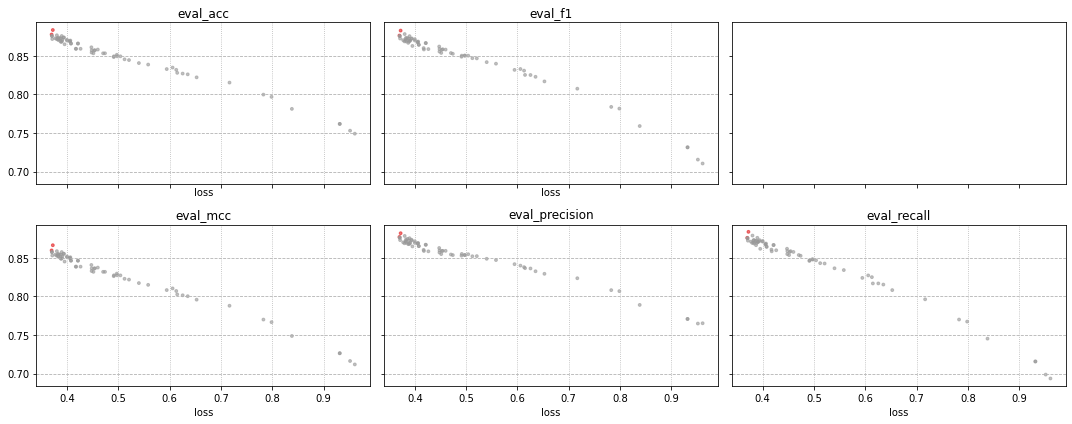

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(trial_df.eval_loss, trial_df[col], c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

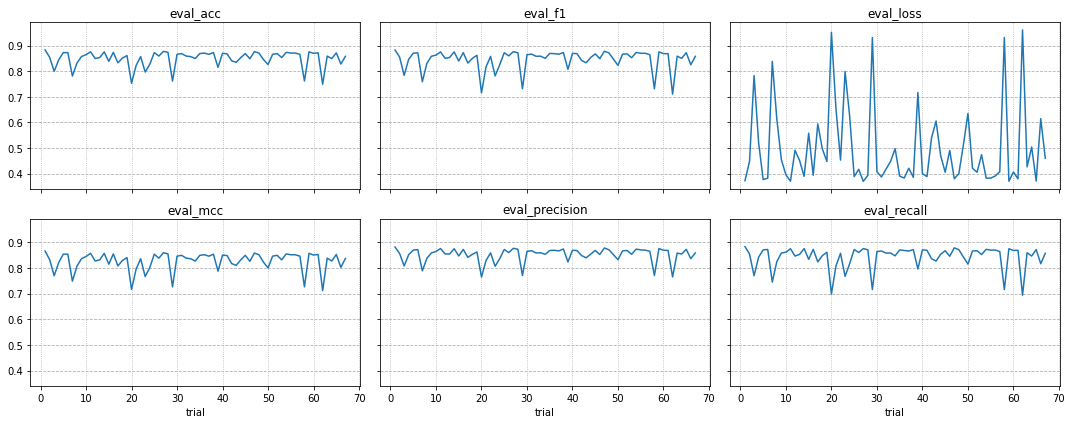

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()